(example_cower)=
# Cost of Wind Energy Review: 2025 Edition

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/NREL/WAVES/main?filepath=examples)

Be sure to install `pip install "waves[examples]"` (or `pip install ".[examples]"`) to work with
this example.

This example will walk through the process of running a subset of the current year's Cost of Wind
Energy Review (COWER) analysis to demonstrate an analysis workflow. Please note, that this is not
the exact workflow because it has been broken down to highlight some of the key features of WAVES.
Similarly, this will stay up to date with WAVES's dependencies, namely ORBIT, WOMBAT, and FLORIS,
so results may change slightly between this *example* relying on the configurations and the
published results.

````{note}
To run these examples from the command line, the below command can be used, which will dipslay and
save the results by default, with an option to turn those features off. Use `waves --help` for more
information in the command line wherever WAVES is installed.

```bash
# NOTE: This is run from the top level of WAVES/

# Run one example
waves library/base base_osw_fixed.yaml

# Run both examples, but don't save the results
waves library/base base_osw_fixed.yaml base_osw_floating.yaml --no-save-report
```
````

## Imports and Styling

In [1]:
from time import perf_counter
from pathlib import Path

import pandas as pd

from waves import Project
from waves.utilities import load_yaml

# Update core Pandas display settings
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Configuration

First, we need to set the library path, and then we'll load the configuration file, to show some of
the configurations. For a complete guide and definition, please see either the
[API documentation](https://nrel.github.io/WAVES/api.html) or the
[How to use WAVES guide](https://nrel.github.io/WAVES/getting_started.html#configuring).

````{warning}
If your FLORIS installation is <3.6, then the FLORIS configuration files in
`library/base/project/config/` will have to be updated so that line 107 (same line number for
fixed bottom and floating) is using an absolute path like the example below.

```yaml
# original, set to work with FLORIS >= 3.6
turbine_library_path: ../../turbines

# updated absolute path, replace <path_to_waves> in your own files
turbine_library_path: <path_to_waves>/WAVES/library/base/turbines/
```
````

In [2]:
library_path = Path("../library/base")
config_fixed = load_yaml(library_path / "project/config", "base_osw_fixed.yaml")
config_floating = load_yaml(library_path / "project/config", "base_osw_floating.yaml")

# This example was designed prior to the FLORIS 3.6 release, so the path to the turbine library in
# FLORIS must be manually updated, but this example must work for all users, so a dynamic method
# is used below, ensuring this works for all users.
config_fixed["floris_config"] = load_yaml(library_path / "project/config", config_fixed["floris_config"])
config_floating["floris_config"] = load_yaml(library_path / "project/config", config_floating["floris_config"])

config_fixed["floris_config"]["farm"]["turbine_library_path"] = library_path / "turbines"
config_floating["floris_config"]["farm"]["turbine_library_path"] = library_path / "turbines"

Now, we'll create a Project for each of the fixed bottom and floating offshore scenarios, showing
the time it takes to initialize each project. Note that we're initializing using the
`Project.from_dict()` `classmethod` because the configurations are designed to also work with the
WAVES command line interface (CLI).

In [3]:
# Add in the library path for both configurations
config_fixed.update({"library_path": library_path,})
config_floating.update({"library_path": library_path,})

start = perf_counter()

project_fixed = Project.from_dict(config_fixed)

end = perf_counter()
print(f"Fixed bottom loading time: {(end-start):,.2f} seconds")

start = perf_counter()

project_floating = Project.from_dict(config_floating)

end = perf_counter()
print(f"Floating loading time: {(end-start):,.2f} seconds")

ORBIT library intialized at '/Users/rhammond/GitHub_Public/NREL/WAVES/library/base'
No LandBOSSE configuration provided, skipping model setup.
Fixed bottom loading time: 1.03 seconds
No LandBOSSE configuration provided, skipping model setup.
Floating loading time: 0.81 seconds


Missing data in columns ['bury_speed']; all values will be calculated.
Missing data in columns ['bury_speed']; all values will be calculated.


Fixed bottom loading time: 1.03 seconds
No LandBOSSE configuration provided, skipping model setup.


Floating loading time: 0.81 seconds


Missing data in columns ['bury_speed']; all values will be calculated.

### Visualize the wind farm

Both projects use the same layout, so we'll plot just the fixed bottom plant, noting that the self-connected line at the "OSS1" indicates the unmodeled interconnection point via a modeled export cable.

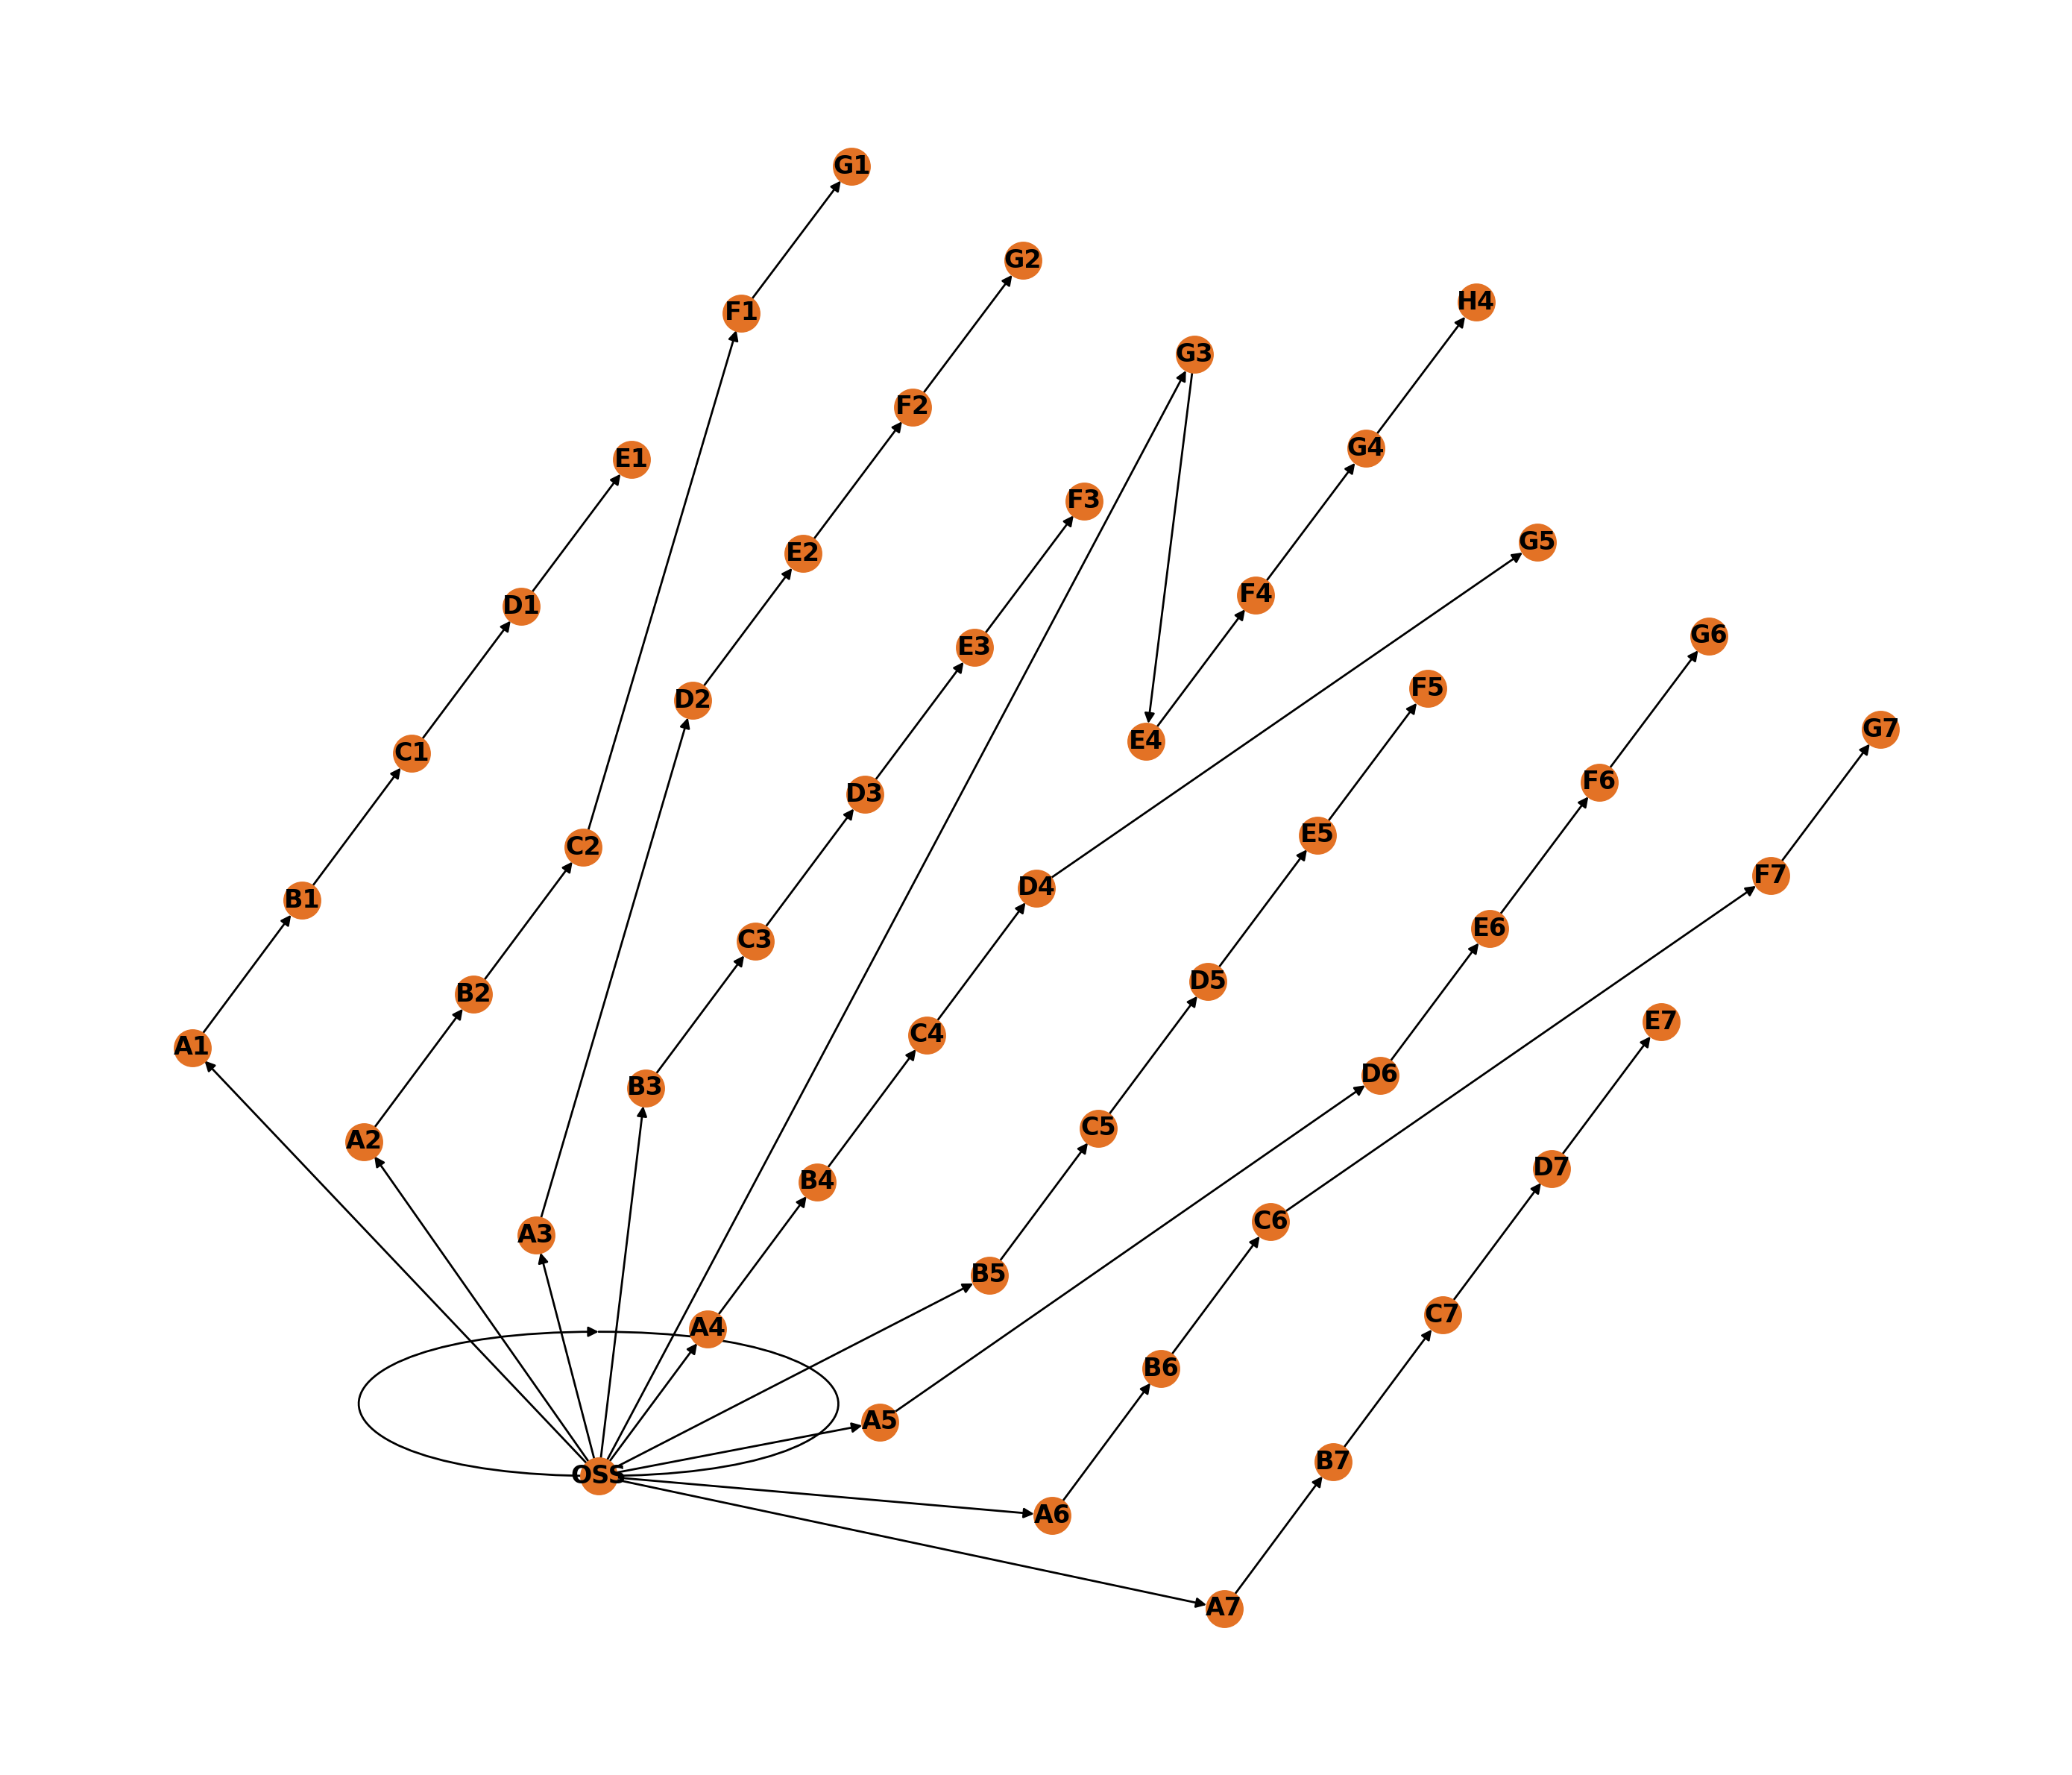

In [4]:
project_fixed.plot_farm()

## Run the Projects

Now we'll, run all both the fixed-bottom and floating offshore wind scenarios. Notice that there are
additional parameters to use for running the FLORIS model in WAVES: `"wind_rose"` and
`"time_series"`. While time series is more accurate, it can take multiple hours to run for a
20-year, hourly timeseries, and lead to similar results, so we choose the model that will take only
a few minutes to run, instead.

Additionally, the wind rose can be computed based on the full weather profile,
`full_wind_rose=True`, for little added computation since WAVES computes a wind rose for each month
of the year, for a more accurate energy output. However, we're using just the weather profile used
in the O&M phase: `full_wind_rose=False`.

In [5]:
start = perf_counter()
project_fixed.run(
    full_wind_rose=False,  # use the WOMBAT date range
    floris_kwargs={"cut_in_wind_speed": 3.0, "cut_out_wind_speed": 25.0}  # standard ws range
)
project_fixed.wombat.env.cleanup_log_files()  # Delete logging data from the WOMBAT simulations
end = perf_counter()
print(f"Fixed run time: {end - start:,.2f} seconds")

start = perf_counter()
project_floating.run(
    full_wind_rose=False,
    floris_kwargs=dict(cut_in_wind_speed=3.0, cut_out_wind_speed=25.0)
)
project_floating.wombat.env.cleanup_log_files()  # Delete logging data from the WOMBAT simulations
end = perf_counter()

print(f"Floating run time: {end - start:,.2f} seconds")

Missing data in columns ['bury_speed']; all values will be calculated.
'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
invalid value encountered in divideRuntimeWarning: /Users/rhammond/miniconda3/envs/waves-nrel/lib/python3.14/site-packages/floris/core/wake_deflection/gauss.py:495
invalid value encountered in divide
Missing data in columns ['bury_speed']; all values will be calculated.
'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.RuntimeWarning: /Users/rhammond/miniconda3/envs/waves-nrel/lib/python3.14/site-packages/floris/core/wake_deflection/gauss.py:325
invalid value encountered in divide
invalid value encountered in divide


'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.

invalid value encountered in divideRuntimeWarning: /Users/rhammond/miniconda3/envs/waves-nrel/lib/python3.14/site-packages/floris/core/wake_deflection/gauss.py:495
invalid value encountered in divide

Fixed run time: 46.42 seconds
Floating run time: 47.52 seconds


Missing data in columns ['bury_speed']; all values will be calculated.

'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.RuntimeWarning: /Users/rhammond/miniconda3/envs/waves-nrel/lib/python3.14/site-packages/floris/core/wake_deflection/gauss.py:325
invalid value encountered in divide

invalid value encountered in divide

Floating run time: 47.52 seconds


Both of these examples can also be run via the CLI, though the FLORIS `turbine_library_path`
configuration will have to be manually updated in each file to ensure the examples run.

```console
waves path/to/library/base/ base_osw_fixed.yaml base_osw_floating.yaml --no-save-report
```

(example_cower:results)=
## Gather the results

Another of the conveniences with using WAVES to run all three models is that some of the core
metrics are wrapped in the `Project` API, with the ability to generate a report of a selection of
the metrics.

Below, we define the inputs for the report by the following paradigm, where the `"metric"` and
`"kwargs"` keys must not be changed to ensure their values are read correctly. See the following
setup for details.

```python
configuration_dictionary = {
    "Descriptive Name of Metric": {
        "metric": "metric_method_name",
        "kwargs": {
            "metric_kwarg_1": "kwarg_1_value", ...
        }
    }
}
```

Below, it can be seen that many metrics do not have the `"kwargs"` dictionary item. This is because
an empty dictionary can be assumed to be used when no values need to be configured. In other words,
the default method configurations will be relied on, if not otherwise specified.

In [6]:
metrics_configuration = {
    "# Turbines": {"metric": "n_turbines"},
    "Turbine Rating (MW)": {"metric": "turbine_rating"},
    "Project Capacity (MW)": {
        "metric": "capacity",
        "kwargs": {"units": "mw"}
    },
    "# OSS": {"metric": "n_substations"},
    "Total Export Cable Length (km)": {"metric": "export_system_total_cable_length"},
    "Total Array Cable Length (km)": {"metric": "array_system_total_cable_length"},
    "CapEx ($)": {"metric": "capex"},
    "CapEx per kW ($/kW)": {
        "metric": "capex",
        "kwargs": {"per_capacity": "kw"}
    },
    "OpEx ($)": {"metric": "opex"},
    "OpEx per kW ($/kW)": {"metric": "opex", "kwargs": {"per_capacity": "kw"}},
    "AEP (MWh)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "aep": True}
    },
    "AEP per kW (MWh/kW)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "per_capacity": "kw", "aep": True}
    },
    "Net Capacity Factor (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "net"}
    },
    "Gross Capacity Factor (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "gross"}
    },
    "Energy Availability (%)": {
        "metric": "availability",
        "kwargs": {"which": "energy"}
    },
    "LCOE ($/MWh)": {"metric": "lcoe"},
}


# Define the final order of the metrics in the resulting dataframes
metrics_order = [
    "# Turbines",
    "Turbine Rating (MW)",
    "Project Capacity (MW)",
    "# OSS",
    "Total Export Cable Length (km)",
    "Total Array Cable Length (km)",
    "FCR (%)",
    "Offtake Price ($/MWh)",
    "CapEx ($)",
    "CapEx per kW ($/kW)",
    "OpEx ($)",
    "OpEx per kW ($/kW)",
    "Annual OpEx per kW ($/kW)",
    "Energy Availability (%)",
    "Gross Capacity Factor (%)",
    "Net Capacity Factor (%)",
    "AEP (MWh)",
    "AEP per kW (MWh/kW)",
    "LCOE ($/MWh)",
]

capex_order = [
    "Array System",
    "Export System",
    "Offshore Substation",
    "Substructure",
    "Scour Protection",
    "Mooring System",
    "Turbine",
    "Array System Installation",
    "Export System Installation",
    "Offshore Substation Installation",
    "Substructure Installation",
    "Scour Protection Installation",
    "Mooring System Installation",
    "Turbine Installation",
    "Soft",
    "Project",
]

Before we generate the report, let's see a CapEx breakdown of each scenario. To do this, we'll
access ORBIT's `ProjectManager` object directly to access model-specific functionality. This is
available for each model via:

- `project.orbit`: provides access to ORBIT's `ProjectManager`
- `project.wombat` provides access to WOMBAT's `Simulation`
- `project.floris` provides access to FLORIS's `FlorisInterface`

In [7]:
# Capture the CapEx breakdown from each scenario
df_capex_fixed = pd.DataFrame(
    project_fixed.orbit.capex_breakdown.items(),
    columns=["Component", "CapEx ($) - Fixed"]
)
df_capex_floating = pd.DataFrame(
    project_floating.orbit.capex_breakdown.items(),
    columns=["Component", "CapEx ($) - Floating"]
)

# Compute the normalized CapEx for each scenario
df_capex_fixed["CapEx ($/kW) - Fixed"] = df_capex_fixed["CapEx ($) - Fixed"] / project_fixed.capacity("kw")
df_capex_floating["CapEx ($/kW) - Floating"] = df_capex_floating["CapEx ($) - Floating"] / project_floating.capacity("kw")

# Combine the results into one, easy to view dataframe
df_capex = df_capex_fixed.merge(
    df_capex_floating,
    on="Component",
    how="outer",
).fillna(0.0).set_index("Component")
df_capex = df_capex.iloc[pd.Categorical(df_capex.index, capex_order).argsort()]
df_capex

,CapEx ($) - Fixed,CapEx ($/kW) - Fixed,CapEx ($) - Floating,CapEx ($/kW) - Floating
Component,,,,
Array System,"229,580,101.77",382.63,"280,103,447.08",466.84
Export System,"177,208,497.34",295.35,"160,602,563.75",267.67
Offshore Substation,"223,904,483.10",373.17,"222,987,040.46",371.65
Substructure,"426,246,404.44",710.41,"800,743,873.88","1,334.57"
Scour Protection,"5,346,000.00",8.91,0.00,0.00
Mooring System,0.00,0.00,"339,550,977.65",565.92
Turbine,"1,062,000,000.00","1,770.00","1,062,000,000.00","1,770.00"
Array System Installation,"165,119,369.39",275.20,"281,336,257.72",468.89
Export System Installation,"137,456,836.78",229.09,"159,057,857.16",265.10


Now, let's generate the report, and then add in some additional reporting variables.

In [8]:
project_name_fixed = "Fixed"
project_name_floating = "Floating"

# Generate the reports using WAVES and the above configurations
# NOTE: the results are transposed to view them more easily for the example, otherwise
# each row would be a project, which is helpful for combining the results of many scenarios
report_df_fixed = project_fixed.generate_report(metrics_configuration, project_name_fixed).T
report_df_floating = project_floating.generate_report(metrics_configuration, project_name_floating).T

# Gather some additional metadata and results from the projects
n_years_fixed = project_fixed.operations_years
n_years_floating = project_floating.operations_years
additional_reporting_fixed = pd.DataFrame(
    [
        ["FCR (%)", project_fixed.fixed_charge_rate],
        ["Offtake Price ($/MWh)", project_fixed.offtake_price],
        [
            "Annual OpEx per kW ($/kW)",
            report_df_fixed.loc["OpEx per kW ($/kW)", project_name_fixed] / n_years_fixed
        ],
    ],
    columns=["Project"] + report_df_fixed.columns.tolist(),
).set_index("Project")

additional_reporting_floating = pd.DataFrame(
    [
        ["FCR (%)", project_floating.fixed_charge_rate],
        ["Offtake Price ($/MWh)", project_floating.offtake_price],
        [
            "Annual OpEx per kW ($/kW)",
            report_df_floating.loc["OpEx per kW ($/kW)", project_name_floating] / n_years_floating
        ],
    ],
    columns=["Project"] + report_df_floating.columns.tolist(),
).set_index("Project")

# Combine the additional metrics to the generated report
report_df_fixed = pd.concat((report_df_fixed, additional_reporting_fixed), axis=0).loc[metrics_order]
report_df_floating = pd.concat((report_df_floating, additional_reporting_floating), axis=0).loc[metrics_order]

# Combine both reports into one, easy to view dataframe
report_df = report_df_fixed.join(
    report_df_floating,
    how="outer",
).fillna(0.0)
report_df.index.name = "Metrics"

# Format percent-based rows to show as such, not as decimals
report_df.loc[report_df.index.str.contains("%")] *= 100

report_df

,Fixed,Floating
Metrics,,
# OSS,1.00,1.00
# Turbines,50.00,50.00
AEP (MWh),"2,264,052.52","2,498,120.63"
AEP per kW (MWh/kW),3.77,4.16
Annual OpEx per kW ($/kW),131.47,141.42
CapEx ($),"3,675,473,514.25","4,943,452,887.87"
CapEx per kW ($/kW),"6,125.79","8,239.09"
Energy Availability (%),93.93,91.37
FCR (%),6.38,7.06
